# Aprendizaje automático y aplicaciones

## Guía de trabajos prácticos del Encuentro 6

---
$A^3$ @ FI-UNER : 2021

Seleccione uno de los modelos presentados en clase para resolver el problema de clasificación
de eventos masticatorios, realice modificaciones y obtenga los resultados para la partición de
test. También puede proponer un nuevo modelo neuronal si lo prefiere.

Luego de resolver el ejercicio, deberá presentar:

* Documento justificando las modificaciones realizadas sobre el modeloseleccionado. En caso de proponer un nuevo modelo, deberá explicar la intuición detrás de la propuesta. 

*   Notebook con el código del modelo modificado/propuesto. Se espera que sea posible
reproducir los pasos seguidos.
*   Modelo entrenado (formato ".pt") junto al archivo de predicciones obtenido con el
modelo.







Seleccionamos el modelo del Perceptrón Multicapa para encarar el problema.

Descargamos los datos del problema:

Importamos las librerías que vamos a utilizar

In [1]:
import os
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy
from scipy.io import wavfile
from scipy import signal

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter  # Registro de medidas

from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Utilizará GPU si está disponible

In [2]:
main_folder = "ProblemaIALitoral"
if os.path.split(os.getcwd())[1] != main_folder:
    if not os.path.exists(main_folder):
        os.makedirs(main_folder)
    os.chdir(main_folder)

In [3]:
!wget --quiet --no-clobber https://www.dropbox.com/s/d12x5vknrk9yek1/data.zip
!wget --quiet --no-clobber https://www.dropbox.com/s/qoyduoa5prupyzr/test_files.csv
!wget --quiet --no-clobber https://www.dropbox.com/s/z1cwznln0gfpw32/train_labels.csv

In [4]:
if not os.path.exists("./data") and os.path.isfile("data.zip"):
    with zipfile.ZipFile('data.zip', 'r') as zip_ref:
        zip_ref.extractall('.')

In [5]:
!ls -l

total 82484
drwxr-xr-x 2 root root    69632 Oct 19 14:13 data
-rw-r--r-- 1 root root 84347854 Oct 19 14:13 data.zip
-rw-r--r-- 1 root root     7764 Oct 19 14:13 test_files.csv
-rw-r--r-- 1 root root    30554 Oct 19 14:13 train_labels.csv


In [6]:
df = pd.read_csv('train_labels.csv')
df

,filename,pasture,height,label
0,4,alfalfa,tall,2
1,9,alfalfa,tall,2
2,10,alfalfa,tall,1
3,11,alfalfa,tall,2
4,13,alfalfa,tall,2
...,...,...,...,...
1527,3073,fescue,tall,1
1528,3075,fescue,tall,1
1529,3077,fescue,tall,1
1530,3079,fescue,tall,1


Vemos la distribución de las etiquetas

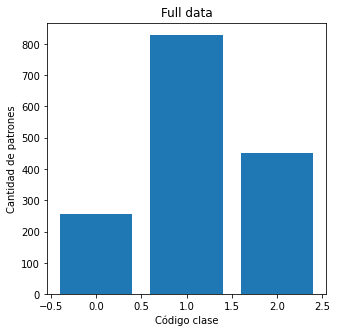

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.hist(df.label, bins=[-.5, .5, 1.5, 2.5], rwidth=0.8)
ax.set_ylabel("Cantidad de patrones")
ax.set_xlabel("Código clase")
ax.set_title('Full data');

In [8]:
# Particiono os datos en train y validation
X_train, X_val = train_test_split(df,
                                  train_size=0.8,
                                  shuffle=True,
                                  random_state=42,
                                  stratify=df.label)

# Guardo las particiones en archivos
X_train.to_csv('train_files.csv')
X_val.to_csv('validation_files.csv')

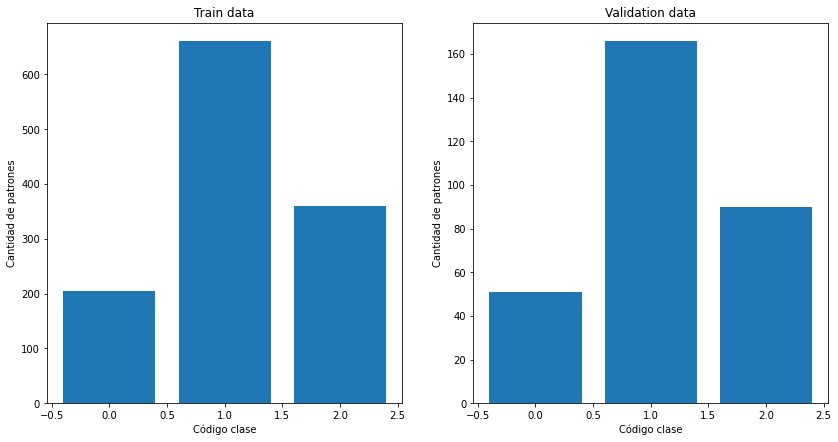

In [9]:
particiones = ['train', 'validation']

fig, ax = plt.subplots(1, len(particiones), figsize=(7*len(particiones),7))

for idx, particion in enumerate(particiones):
    
    df = pd.read_csv(f'{particion}_files.csv')
    
    ax[idx].hist(df.label, bins=[-.5, .5, 1.5, 2.5], rwidth=0.8)
    ax[idx].set_ylabel("Cantidad de patrones")
    ax[idx].set_xlabel("Código clase")
    ax[idx].set_title(f'{particion.capitalize()} data')

In [11]:
#Esta función es la vista en clases, realiza la extracción de características de una señal sonora.
def get_features(raw_signal, fs, threshold=0.0230, cutoff_freq=5):
    '''
    Devuelve las features de interés para la señal
    
    INPUTS:
    -------
    - raw_signal: [numpy.ndarray] Señal a procesar.
    - fs: [float] Frecuencia de muestreo.
    - threshold: [float] umbral para duracion y signo de la pendiente de la envolvente.
    - cutoff_freq: [float] Frecuencia de corte del filtro pasabajo usado para calcular la envolvente.
    '''

    # Rectification
    rectified_signal = np.abs(raw_signal)

    # Low-pass filtering -> envelope
    sos_butter = scipy.signal.butter(2, cutoff_freq, 'lowpass', output="sos", fs=fs)
    envelope = scipy.signal.sosfiltfilt(sos_butter, rectified_signal, axis=0)

    above_thres = envelope >= threshold  # arreglo booleano para restringir zona de calculo

    # variables y señales auxiliares
    max_pos = np.argmax(envelope)  # posicion del maximo en la ventana
    # al multiplicar por above_thres hace cero por debajo del umbral (enmascara)
    envelope_slope_sign = np.sign(np.diff(envelope, append=0)) * above_thres
    duration_signal = np.ones(envelope.shape) * above_thres  

    # Caracteristicas
    duration = np.sum(duration_signal) / fs
    zero_crossing = np.count_nonzero(np.abs(np.diff(envelope_slope_sign)))
    amplitude = np.max(rectified_signal)
    ratio = np.trapz(envelope[:max_pos], axis=0) / np.trapz(envelope, axis=0)
    std = np.std(raw_signal)

    data = [duration, zero_crossing, amplitude, ratio, std]
    
    return data

In [13]:
#Esto también sale de los visto en clases, es la definición de la clase WaveDataset, funciones y propiedades.
class WaveDataset(Dataset):
    
    #=====================================================
    def __init__(self, root_path, annotation_file, transform=None, target_transform=None):
        """Construye un dataset desde carpeta de wav y csv de labels."""
        
        self.root_path = root_path
        
        # Crea una lista de nombres y etiquetas a partir del csv
        ds = pd.read_csv(annotation_file)
        self.filenames = list(ds['filename'])
        
        if 'label' in ds.columns:
            # Si existe una columna de labels la toma del csv
            self.labels = ds['label'].values
        else:
            # Caso contrario, los labels son todos -1
            self.labels = -np.ones(len(self.filenames))
        
        self.cache = dict()
        
        self.transform = transform
        self.target_transform = target_transform
    
    #=====================================================
    def __len__(self):
        """Cantidad de patrones en el dataset."""
        
        return len(self.labels)
    
    
    #=====================================================
    def __getitem__(self, idx):
        """Retorna la tupla (data, fs, label) en la posicion index."""
        
        if idx in self.cache:
            data, label = self.cache[idx]
        else:
            # Lee el archivo wav y guarda (muestras, label) en cache
            fname = f"{self.filenames[idx] :04d}.wav"
            
            fpath = os.path.join(self.root_path, fname)
            
            fs, raw_signal = wavfile.read(fpath) # lectura de wavs con scipy
            raw_signal = raw_signal / np.iinfo(raw_signal.dtype).max  # Reescala entre -1 y 1
            
            #-----------------------------------------
            # EXTRAER FEATURES
            #-------------------
            
            data = get_features(raw_signal, fs, threshold=0.0230, cutoff_freq=5)
            
            #-----------------------------------------
            
            label = self.labels[idx]
            
            self.cache[idx] = (data, label)
        
        #--------------------------------------
        if self.transform:
            pass
        if self.target_transform:
            pass
        #--------------------------------------
        
        return torch.tensor(data).type(torch.FloatTensor), torch.tensor(label).type(torch.LongTensor)
    
    
    @property
    #=====================================================
    def get_n_classes(self):
        """Devuelve el número de clases en el dataset"""
        return len(set(self.labels))
    
    @property
    #=====================================================
    def get_weigh_by_class(self):
        """Devuelve la proporcion de ejemplos por clase"""
        _classes = list(set(self.labels))
        _classes.sort()
        
        N = torch.tensor([(self.labels==c).sum() for c in _classes])
        
        weights = 1/N
        
        return weights/weights.norm()

In [14]:
# CARGO DATASETS
train_data = WaveDataset(root_path='data', annotation_file='train_files.csv')
val_data = WaveDataset(root_path='data', annotation_file='validation_files.csv')
test_data = WaveDataset(root_path='data', annotation_file='test_files.csv')

In [15]:
# CONSTRUCCIÓN DEL DATALOADER
train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False)

In [17]:
# CONSTRUCCIÓN DEL MODELO NEURONAL
class MLP(nn.Module):
    '''
    MLP con 2 capas: Entrada, salida.
    Este modelo es equivalente al anterior. La diferencia está en que genera
    un "bloque" de procesamiento que puede ejecutarse como un único elemento.
    
    '''
    
    #===========================
    def __init__(self, n_inputs=2, layers=[3], n_outputs=1):
        
        super(MLP, self).__init__()
        
        self.net = nn.ModuleList([nn.Linear(n_inputs, layers[0], bias=True)])
        self.net.append(nn.Sigmoid())
        
        # Solo se ejecuta si len(layers) > 1
        for i in range(len(layers)-1):
            self.net.append(nn.Linear(layers[i], layers[i+1], bias=True))
            self.net.append(nn.Sigmoid())
        
        self.net.append(nn.Linear(layers[-1], n_outputs, bias=True))
    
    
    #===========================
    def forward(self, x):
        
        y = x
        
        for i, layer in enumerate(self.net):
            y = self.net[i](y)
        
        return y  # salida de la red

In [18]:
def train_step(model, dataloader, loss_criterion, device):
    
    model.train()  # Calcula gradientes
    
    cummulated_loss = 0
    
    for idx,(X,y) in enumerate(dataloader):

        #-----------------------------------------------------
        # Convierto los datos en tensores diferenciables
        #-----------------------------------------------------
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()  # Se limpia el caché del optimizador
        
        #----------------
        # Forward pass
        #----------------
        y_pred = model(X)

        #----------------
        # Compute Loss
        #----------------
        loss = loss_criterion(y_pred.squeeze(), y)
        
        cummulated_loss += loss.item()
        
        #----------------
        # Backward pass
        #----------------
        loss.backward()
        optimizer.step()
        
    #------------------------------------
    
    N_batches = idx+1  # numero batches, comenzando en 1
    cummulated_loss /= N_batches
    
    return cummulated_loss, model

In [19]:
def predict_step(model, dataloader, loss_criterion, device):
    
    model.eval()  # No calcula gradientes
    
    cummulated_loss = 0
    
    Y = torch.tensor([])
    Yp = torch.tensor([])
    
    for idx,(X,y) in enumerate(dataloader):
        
        Y = torch.hstack( (Y,y.flatten()) )
        
        #-----------------------------------------------------
        # Convierto los datos en tensores diferenciables
        #-----------------------------------------------------
        X = X.to(device)
        y = y.to(device)
        
        #----------------
        # Forward pass
        #----------------
        y_pred = model(X)
        
        Yp = torch.hstack( (Yp, y_pred.cpu().argmax(dim=1)) )

        #----------------
        # Compute Loss
        #----------------
        loss = loss_criterion(y_pred.squeeze(), y)
        
        cummulated_loss += loss.item()
    
    
    N_batches = idx+1  # numero batches, comenzando en 1
    cummulated_loss /= N_batches
    
    
    Acc = torch.sum(Yp == Y)/ len(Y)
    
    #------------------
    
    return cummulated_loss, Acc

In [20]:
def inference(model, dataloader, loss_criterion, device):
    
    model.eval()  # No calcula gradientes
    
    Y = torch.tensor([])
    Yp = torch.tensor([])
    
    for idx,(X,y) in enumerate(dataloader):
        
        Y = torch.hstack( (Y,y.flatten()) )
        
        #-----------------------------------------------------
        # Convierto los datos en tensores diferenciables
        #-----------------------------------------------------
        X = X.to(device)
        y = y.to(device)
        
        #----------------
        # Forward pass
        #----------------
        y_pred = model(X)
        
        Yp = torch.hstack( (Yp, y_pred.cpu().argmax(dim=1)) )
    
    #------------------
    
    return Yp

In [94]:
# DEFINO ESTRUCTURA DEL MODELO
parameters = {'n_inputs':5,
              'layers':[15], #Se explica esta elección luego del entrenamiento
              'n_outputs':train_data.get_n_classes}

# INICIALIZO MODELO
model = MLP(**parameters)
model.to(device)


# DEFINO ESTRUCTURA PARA GUARDAR MEDIDAS
measures = {
            'trn_loss': [],
            'trn_acc': [],
            'val_loss': [],
            'val_acc': []
           }


#-------------------------------------------------------
# Definimos el criterio de error (métrica a minimizar)
# y trasladamos al device [CPU|GPU]
#-------------------------------------------------------
loss_criterion = torch.nn.CrossEntropyLoss(weight=train_data.get_weigh_by_class, reduction='mean').to(device)


#-------------------------------------
# Definimos el optimizador a utilizar
#-------------------------------------
optimizer = optim.SGD(model.parameters(), lr=5e-2, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=1e-3)

# DEFINIMOS PARAMETROS
best_loss = 1E6
best_model = model.state_dict()
best_epoch = 0
counter = 0

MAX_EPOCHS = 1000  # DEFINIMOS MAXIMO DE EPOCAS DE ENTRENAMIENTO
epoch = 0  # INICIALIZAMOS CONTADOR DE EPOCAS

In [95]:
# Visualizamos el modelo
print(model)

MLP(
  (net): ModuleList(
    (0): Linear(in_features=5, out_features=15, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=15, out_features=3, bias=True)
  )
)


In [96]:
# Inicializo logger
writer = SummaryWriter('logs/')

In [97]:
while (epoch < MAX_EPOCHS) and (counter < 200):
    
    #------------
    # TRAIN
    #------------
    trn_loss, model = train_step(model, train_dataloader, loss_criterion, device)
    writer.add_scalar("Loss/train1", trn_loss, epoch)
    
    trn_loss, trn_acc = predict_step(model, train_dataloader, loss_criterion, device)  # TRAIN EVALUATION
    writer.add_scalar("Loss/train2", trn_loss, epoch)
    writer.add_scalar("Acc/train", trn_acc, epoch)

    val_loss, val_acc = predict_step(model, val_dataloader, loss_criterion, device)  # VALIDATION EVALUATION
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("Acc/val", val_acc, epoch)
    
    measures['trn_loss'].append(trn_loss)
    measures['trn_acc'].append(trn_acc)
    
    measures['val_loss'].append(val_loss)
    measures['val_acc'].append(val_acc)
    

    #=================================
    if (val_loss < best_loss):
        
        # Actualizo best_loss
        best_loss = val_loss
        best_epoch = epoch
        
        # Guardo mejor modelo
        best_model = model.state_dict()
        counter = 0
    
    else:
        counter += 1
    #=================================

    if (epoch%10) == 0:
        print(f'Epoch {epoch}: trn_loss: {trn_loss:.5}\t val_loss: {val_loss:.5}\t trn_acc: {trn_acc}\t val_acc: {val_acc}\t counter: {counter}')
    
    # Avanzo 1 epoca
    epoch += 1


writer.flush()  # Termina todas las operaciones pendientes
writer.close()  # Cierra el registro

print(f'Best model:\n\nepoch: {best_epoch}\nloss: {best_loss:.5}')

# GUARDO MEJOR MODELO
torch.save(best_model, 'best_model_pytorch.pt')

Epoch 0: trn_loss: 1.0277	 val_loss: 1.0276	 trn_acc: 0.3053061366081238	 val_acc: 0.32573288679122925	 counter: 0
Epoch 10: trn_loss: 0.74474	 val_loss: 0.74131	 trn_acc: 0.7510204315185547	 val_acc: 0.7654722929000854	 counter: 0
Epoch 20: trn_loss: 0.72033	 val_loss: 0.79062	 trn_acc: 0.7502040863037109	 val_acc: 0.7263843417167664	 counter: 2
Epoch 30: trn_loss: 0.71103	 val_loss: 0.75996	 trn_acc: 0.7510204315185547	 val_acc: 0.7459283471107483	 counter: 4
Epoch 40: trn_loss: 0.77759	 val_loss: 0.79417	 trn_acc: 0.6506122350692749	 val_acc: 0.638436496257782	 counter: 4
Epoch 50: trn_loss: 0.66602	 val_loss: 0.72904	 trn_acc: 0.7893877625465393	 val_acc: 0.7947883009910583	 counter: 1
Epoch 60: trn_loss: 0.75684	 val_loss: 0.77135	 trn_acc: 0.6163265109062195	 val_acc: 0.6058632135391235	 counter: 11
Epoch 70: trn_loss: 0.68586	 val_loss: 0.7033	 trn_acc: 0.7208163142204285	 val_acc: 0.7198697328567505	 counter: 5
Epoch 80: trn_loss: 0.66005	 val_loss: 0.68698	 trn_acc: 0.76163268

Para determinar la mejor elección de la cantidad de capas ocultas y la cantidad de neuronas de las mismas fui experimentando, realicé 20 pruebas,de forma sistemática. 

Como primera conclusión, utilizar el optimizador SGD arrojó mejores resultados frente al Adam.

Respecto de la cantidad de capas ocultas, en mi caso resultó mejor utilizar una sola capa, con una cantidad de neuronas de entre el doble o el triple de la cantidad de entradas,es decir, entre 10 y 15 neuronas en la capa oculta.

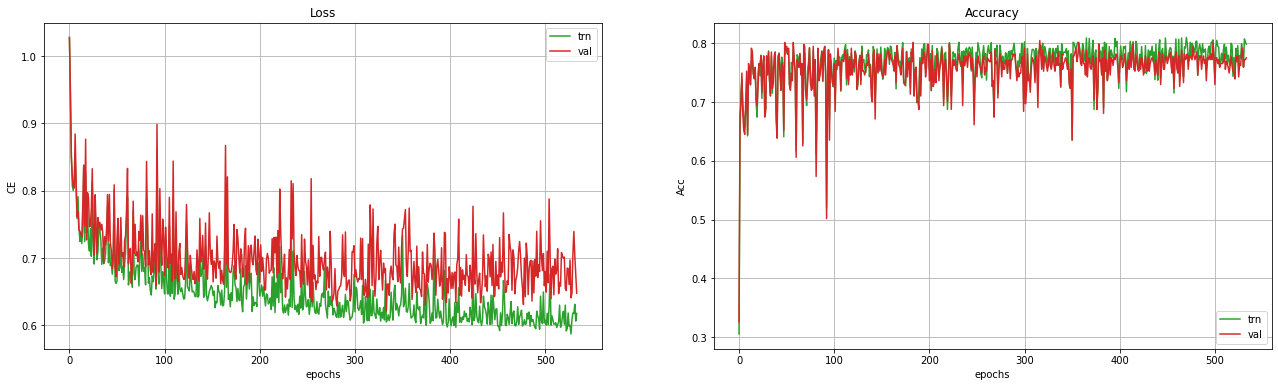

In [98]:
fig, ax = plt.subplots(1,2,figsize=(22,6))

ax[0].plot(measures['trn_loss'], 'C2', label='trn')
ax[0].plot(measures['val_loss'], 'C3', label='val')
ax[0].set_title('Loss')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('CE')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(measures['trn_acc'], 'C2', label='trn')
ax[1].plot(measures['val_acc'], 'C3', label='val')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Acc')
ax[1].grid(True)
ax[1].legend();

PREDICCIONES EN TEST

In [99]:
model = MLP(**parameters)
model.to(device)
model.load_state_dict(best_model)

predicted_labels = inference(model, test_dataloader, loss_criterion, device)  # TEST EVALUATION

print(f'\nPredicciones: {predicted_labels.numpy()}\n')


Predicciones: [0. 2. 0. ... 1. 1. 0.]



In [100]:
test_dataset = pd.read_csv('test_files.csv')

ds = pd.DataFrame({
    'file' : test_dataset.filename, 
    'prediction' : predicted_labels
})

ds.to_csv("predicciones.csv", index=False, header=None)

In [101]:
ds

,file,prediction
0,1,0.0
1,2,2.0
2,3,0.0
3,5,1.0
4,6,2.0
...,...,...
1546,3076,1.0
1547,3078,1.0
1548,3080,1.0
1549,3081,1.0
